### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

### Read the dataset:

In [2]:
df=pd.read_csv("Nifty-50/ADANIPORTS.csv")
df.tail()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
3317,2021-04-26,ADANIPORTS,EQ,725.35,733.0,739.65,728.90,729.2,730.75,733.25,9390549,6.885658e+14,116457.0,838079,0.0892
3318,2021-04-27,ADANIPORTS,EQ,730.75,735.0,757.50,727.35,748.6,749.15,747.67,20573107,1.538191e+15,236896.0,1779639,0.0865
3319,2021-04-28,ADANIPORTS,EQ,749.15,755.0,760.00,741.10,743.4,746.25,751.02,11156977,8.379106e+14,130847.0,1342353,0.1203
3320,2021-04-29,ADANIPORTS,EQ,746.25,753.2,765.85,743.40,746.4,746.75,753.06,13851910,1.043139e+15,153293.0,1304895,0.0942
3321,2021-04-30,ADANIPORTS,EQ,746.75,739.0,759.45,724.50,726.4,730.05,743.35,12600934,9.366911e+14,132141.0,3514692,0.2789


### Analyze the closing prices from dataframe

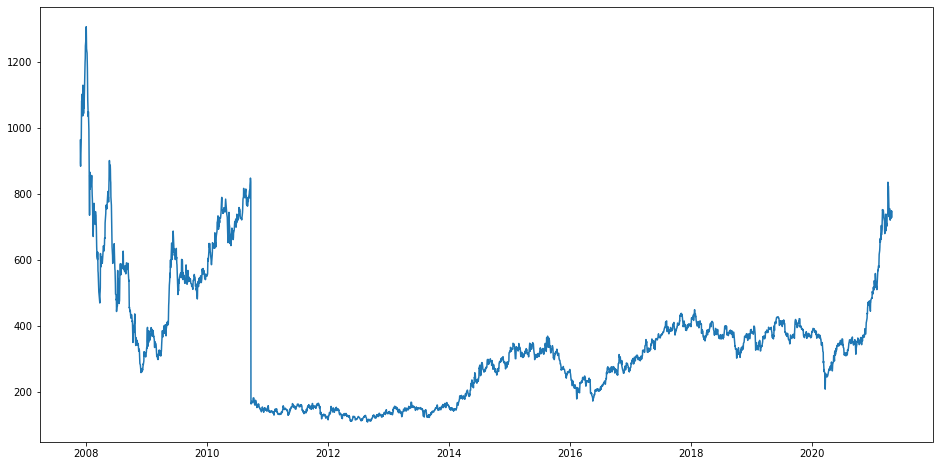

In [3]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

### Sort the dataset on date time and filter “Date” and “Close” columns:

In [4]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=pd.to_datetime((data['Date'][i]))
    new_dataset["Close"][i]=data["Close"][i]

In [5]:
new_dataset.head()


,Date,Close
0,2007-11-27 00:00:00,962.9
1,2007-11-28 00:00:00,893.9
2,2007-11-29 00:00:00,884.2
3,2007-11-30 00:00:00,921.55
4,2007-12-03 00:00:00,969.3


In [6]:
new_dataset

,Date,Close
0,2007-11-27 00:00:00,962.9
1,2007-11-28 00:00:00,893.9
2,2007-11-29 00:00:00,884.2
3,2007-11-30 00:00:00,921.55
4,2007-12-03 00:00:00,969.3
...,...,...
3317,2021-04-26 00:00:00,730.75
3318,2021-04-27 00:00:00,749.15
3319,2021-04-28 00:00:00,746.25
3320,2021-04-29 00:00:00,746.75


### Normalize the new filtered dataset:

In [7]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
final_dataset=new_dataset.values
train_data=final_dataset[0:3000,:]
valid_data=final_dataset[3000:,:]

In [8]:
final_dataset

array([[962.9],
       [893.9],
       [884.2],
       ...,
       [746.25],
       [746.75],
       [730.05]], dtype=object)

In [9]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [10]:
scaled_data

array([[0.71274334],
       [0.65521697],
       [0.64712993],
       ...,
       [0.53211889],
       [0.53253575],
       [0.5186127 ]])

### Build and train the LSTM model

In [11]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50, return_sequences = True))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [12]:
inputs_data = scaler.transform(inputs_data)
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=1)

2940/2940 [==============================] - 149s 51ms/step - loss: 0.0015


### Take a sample of a dataset to make stock price predictions using the LSTM model:

In [13]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test,verbose=0)
# print(X_test.shape)
# print(predicted_closing_price.shape)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

### Save the LSTM model:

In [14]:
lstm_model.save("saved_model.h5")

### Calculating Accuracy


In [17]:
def accuracy_MAPE(actual, pred): 
    return round(np.mean(np.abs((actual - pred) / actual)) * 100, 2)
valid_close_data = valid_data
error_rate_MAPE = accuracy_MAPE(valid_close_data, predicted_closing_price)
print('Mean Absolute Percentage Error:', error_rate_MAPE, '%')
print('Accuracy:', 100 - error_rate_MAPE, '%')

Mean Absolute Percentage Error: 5.99 %
Accuracy: 94.01 %


### Visualize the predicted stock costs with actual stock costs

<ipython-input-18-577cc5efec8f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


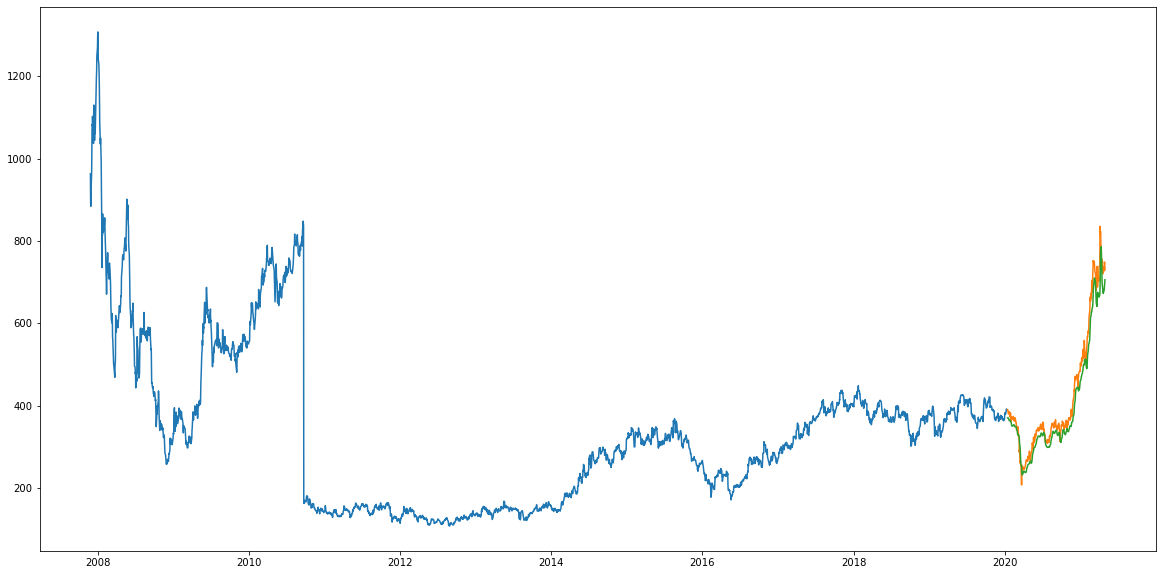

In [18]:
train_data=new_dataset[:3000]
valid_data=new_dataset[3000:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])